# Bathymetry 202405 Double Resolution

* Follow the process in Michael's
  https://github.com/SalishSeaCast/analysis-michael/blob/master/bathymetry/bathymetry-201702.ipynb
  notebook to create the base bathymetry for the 202405 double resolution coordinates

In [1]:
import os
from pathlib import Path
import sys

import arrow
import cmocean
import numpy
import matplotlib.pyplot as plt
import xarray

Python and library versions:

In [2]:
import bottleneck
import h5netcdf
import h5py
import matplotlib
import netCDF4
import pandas
import pyproj
import scipy

print(f"Python {sys.version=}")
print(f"{numpy.__version__=}")
print(f"{xarray.__version__=}")
print(f"{bottleneck.__version__=}")
print(f"{pandas.__version__=}")
print(f"{h5netcdf.__version__=}")
print(f"{h5py.__version__=}")
print(f"{netCDF4.__version__=}")
print(f"{scipy.__version__=}")
print(f"{matplotlib.__version__=}")
print(f"{arrow.__version__=}")
print(f"{cmocean.__version__=}")
print(f"{pyproj.__version__=}")

Python sys.version='3.12.3 | packaged by conda-forge | (main, Apr 15 2024, 18:38:13) [GCC 12.3.0]'
numpy.__version__='1.26.4'
xarray.__version__='2024.6.0'
bottleneck.__version__='1.4.0'
pandas.__version__='2.2.2'
h5netcdf.__version__='1.3.0'
h5py.__version__='3.11.0'
netCDF4.__version__='1.6.5'
scipy.__version__='1.14.0'
matplotlib.__version__='3.8.4'
arrow.__version__='1.3.0'
cmocean.__version__='v3.0.3'
pyproj.__version__='3.6.1'


We need functions from several modules in `analysis-michael/bathymetry/` but they are not packaged.
So,
add their paths in an adjacent clone into `sys.path`.

**This is a expedient hack.
Please don't copy it unless you really know why you are doing it.**

In [3]:
# isolate the probable user-specific part of repo paths to make the notebook portable
repos_prefix = Path("/media/doug/warehouse/MEOPAR/")

In [4]:
sys.path.insert(3, os.fspath(repos_prefix / Path("analysis-michael", "bathymetry")))

sys.path

['/media/doug/warehouse/MEOPAR/analysis-doug',
 '/home/doug/.local/share/JetBrains/Toolbox/apps/pycharm-professional/plugins/python-ce/helpers/pydev',
 '/home/doug/.local/share/JetBrains/Toolbox/apps/pycharm-professional/plugins/python/helpers-pro/jupyter_debug',
 '/media/doug/warehouse/MEOPAR/analysis-michael/bathymetry',
 '/home/doug/conda_envs/2xrez-202111/lib/python312.zip',
 '/home/doug/conda_envs/2xrez-202111/lib/python3.12',
 '/home/doug/conda_envs/2xrez-202111/lib/python3.12/lib-dynload',
 '',
 '/home/doug/conda_envs/2xrez-202111/lib/python3.12/site-packages']

In [5]:
import bathy_helpers
import bathy_prepare

In [6]:
# isolate the probable user-specific part of repo paths to make the notebook portable
repos_prefix = Path("/media/doug/warehouse/MEOPAR/")

coords_paths = {
    "djl_202405": repos_prefix / "grid" / "coordinates_SalishSeaCast_202405.nc",
    "dbl_202405": repos_prefix / "grid" / "coordinates_SalishSeaCast_double_202405.nc",
}

In [7]:
pnw_coast_paths = {
    "coastline": Path("/ocean/rich/more/mmapbase/bcgeo/PNW.mat"),
    "rivers": Path("/ocean/rich/more/mmapbase/bcgeo/PNWrivers.mat"),
}

In [8]:
coastline = scipy.io.loadmat(pnw_coast_paths["coastline"])["ncst"]

In [9]:
rivers = scipy.io.loadmat(pnw_coast_paths["rivers"])["ncst"]

## Create Double Resolution 202405 Bathymetry

### Load and prepare coordinates lons/lats arrays

**NOTE:** All of Michael's bathymetry module functions operate on Numpy arrays.

Load lon/lat coordinate arrays of T and F grid points from coordinates file:

In [10]:
with xarray.open_dataset(coords_paths["dbl_202405"], engine="h5netcdf") as coords:
    glamt = coords.glamt[0].values
    gphit = coords.gphit[0].values
    glamf = coords.glamf[0].values
    gphif = coords.gphif[0].values


Expand the F grid so that its points form complete boxes around the T grid points:

In [11]:
glamfe, gphife = bathy_helpers.expandf(glamf, gphif)


### Re-grid Bathymetry Survey Products on to the Double Resolution Grid

In [12]:
bathy_products_path = repos_prefix / "bathy_surveys"
bathy_paths = {
    "cascadia": bathy_products_path / "Cascadia" / "cascadia.bil",
    "chs2": bathy_products_path / "Data_From_Mitchell_CHS/",
    "bc3": bathy_products_path / "BC3" / "british_columbia_3sec.asc",
}

**NOTE:** The `bathy_prepare.prepare_*()` functions create `.npz` cache files of Numpy arrays with `numpy.savez()`.
Those files need to be deleted if a clean run is required.

In [13]:
cache = bathy_prepare.prepare_cascadia(os.fspath(bathy_paths["cascadia"]), glamt, gphit, glamf, gphif, glamfe, gphife)

cache

1253561 points in 313.7342686653137 s
hit0 report: 8458/1253561=0.6747178637497497%
hit1 report: 1223020/1253561=97.56366064355863%
hit2 report: 0/1253561=0.0%
hit3 report: 0/1253561=0.0%
hit4 report: 0/1253561=0.0%
no hit report: 22083/1253561=1.76162149269162%
points not in domain: 0


'/media/doug/warehouse/MEOPAR/bathy_surveys/Cascadia/cascadia.bil.results.npz'

In [14]:
locals().update(numpy.load(cache))

In [15]:
cache = bathy_prepare.prepare_chs2(f"{os.fspath(bathy_paths['chs2'])}/", glamt, gphit, glamf, gphif, glamfe, gphife)

cache

26676210 points in 443.3248496055603 s
hit0 report: 24498269/26676210=91.8356430692366%
hit1 report: 1813976/26676210=6.799976458424942%
hit2 report: 57074/26676210=0.2139509323100995%
hit3 report: 104494/26676210=0.3917123159549276%
hit4 report: 33198/26676210=0.1244479631851751%
no hit report: 3925/26676210=0.01471348441176614%
points not in domain: 165274


'/media/doug/warehouse/MEOPAR/bathy_surveys/Data_From_Mitchell_CHS/results.npz'

In [16]:
locals().update(numpy.load(cache))

In [17]:
cache = bathy_prepare.prepare_bc3(os.fspath(bathy_paths["bc3"]), glamt, gphit, glamf, gphif, glamfe, gphife)

cache

10317725 points in 399.44330644607544 s
hit0 report: 6864810/10317725=66.53414391253887%
hit1 report: 3443594/10317725=33.37551640502146%
hit2 report: 0/10317725=0.0%
hit3 report: 0/10317725=0.0%
hit4 report: 0/10317725=0.0%
no hit report: 9321/10317725=0.0903396824396851%
points not in domain: 0


'/media/doug/warehouse/MEOPAR/bathy_surveys/BC3/british_columbia_3sec.asc.results.npz'

In [18]:
locals().update(numpy.load(cache))

### Create Bathymetry

Synthesize new bathymetry by weighted sum of Cascadia, BC3, and CHS2 products:

In [19]:
base_dbl_bathy = bathy_helpers.bathyblend(casmean, bc3mean, chs2mean, 1, 5, 10)

Create 202405 double resolution bathymetry by setting coastline at the 2m isobath,
making the minimum water depth 4m,
and making the maximum water depth 428m:

In [20]:
dbl_bathy_202405 = numpy.copy(base_dbl_bathy)
dbl_bathy_202405[(dbl_bathy_202405 > 0) & (dbl_bathy_202405 < 2)] = 0
dbl_bathy_202405[(dbl_bathy_202405 >= 2) & (dbl_bathy_202405 < 4)] = 4
dbl_bathy_202405[dbl_bathy_202405 > 428] = 428

In [21]:
def plot_xy_lonlat(
        bathy, lons, lats, coastline, rivers, x_lims=(0, -1), y_lims=(0, -1), lon_lims=(-126.45, -121.25), lat_lims=(46.8, 51.15)
):
    fig, (ax_xy, ax_lonlat) = plt.subplots(1, 2, figsize=(16, 9))

    masked_bathy = numpy.ma.masked_where(bathy == 0, bathy)

    ax_xy.pcolormesh(masked_bathy, cmap=cmocean.cm.deep_r, vmin=0, vmax=428)
    ax_xy.set_aspect(bathy.shape[1] / bathy.shape[0])
    if x_lims[1] == -1:
        ax_xy.set_xlim(x_lims[0], bathy.shape[1]-1)
    else:
        ax_xy.set_xlim(x_lims)
    if y_lims[1] == -1:
        ax_xy.set_ylim(y_lims[0], bathy.shape[0]-1)
    else:
        ax_xy.set_ylim(y_lims)


    # SalishSeaCast domain boundaries
    ax_lonlat.plot(lons[0, :], lats[0, :], color="black")  # south
    ax_lonlat.plot(lons[:, 0], lats[:, 0], color="black")  # west
    ax_lonlat.plot(lons[-1, :], lats[-1, :], color="black")  # north
    ax_lonlat.plot(lons[:, -1], lats[:, -1], color="black")  # east

    mesh = ax_lonlat.pcolormesh(
        lons, lats, masked_bathy, cmap=cmocean.cm.deep_r, vmin=0, vmax=428
    )
    plt.colorbar(mesh)

    ax_lonlat.plot(coastline[:, 0], coastline[:, 1], color="red", linewidth=0.5)
    ax_lonlat.plot(rivers[:, 0], rivers[:, 1], color="red", linewidth=0.5)

    ax_lonlat.set_aspect(1 / numpy.cos(numpy.median(lats) * numpy.pi / 180))
    ax_lonlat.set_xlim(lon_lims)
    ax_lonlat.set_ylim(lat_lims)

    plt.tight_layout()


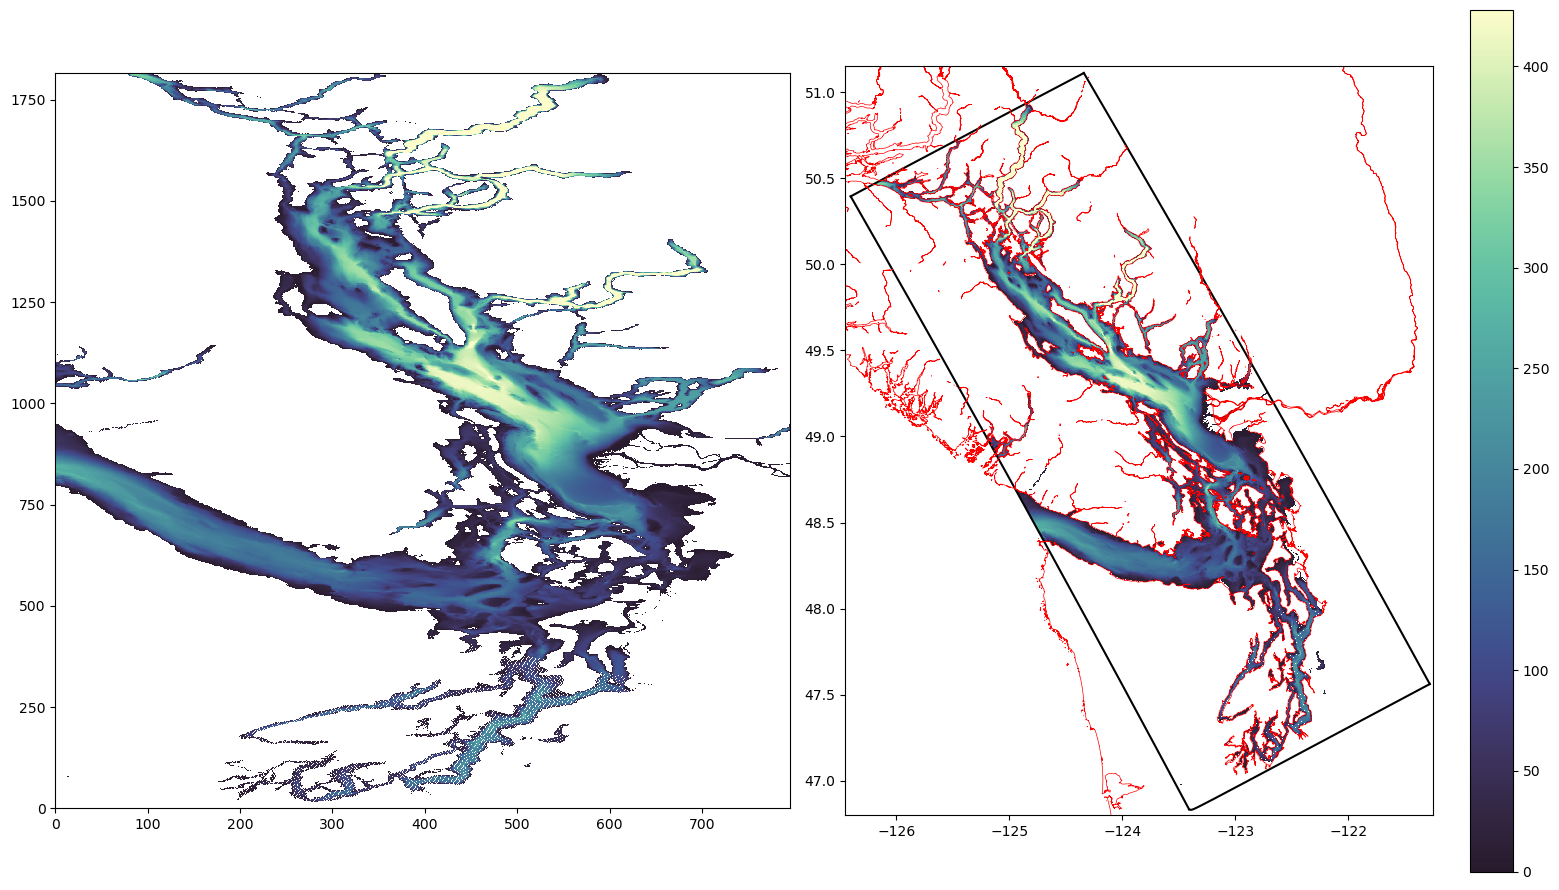

In [22]:
plot_xy_lonlat(dbl_bathy_202405, glamfe, gphife, coastline, rivers)

Stippling in Puget Sound is odd...

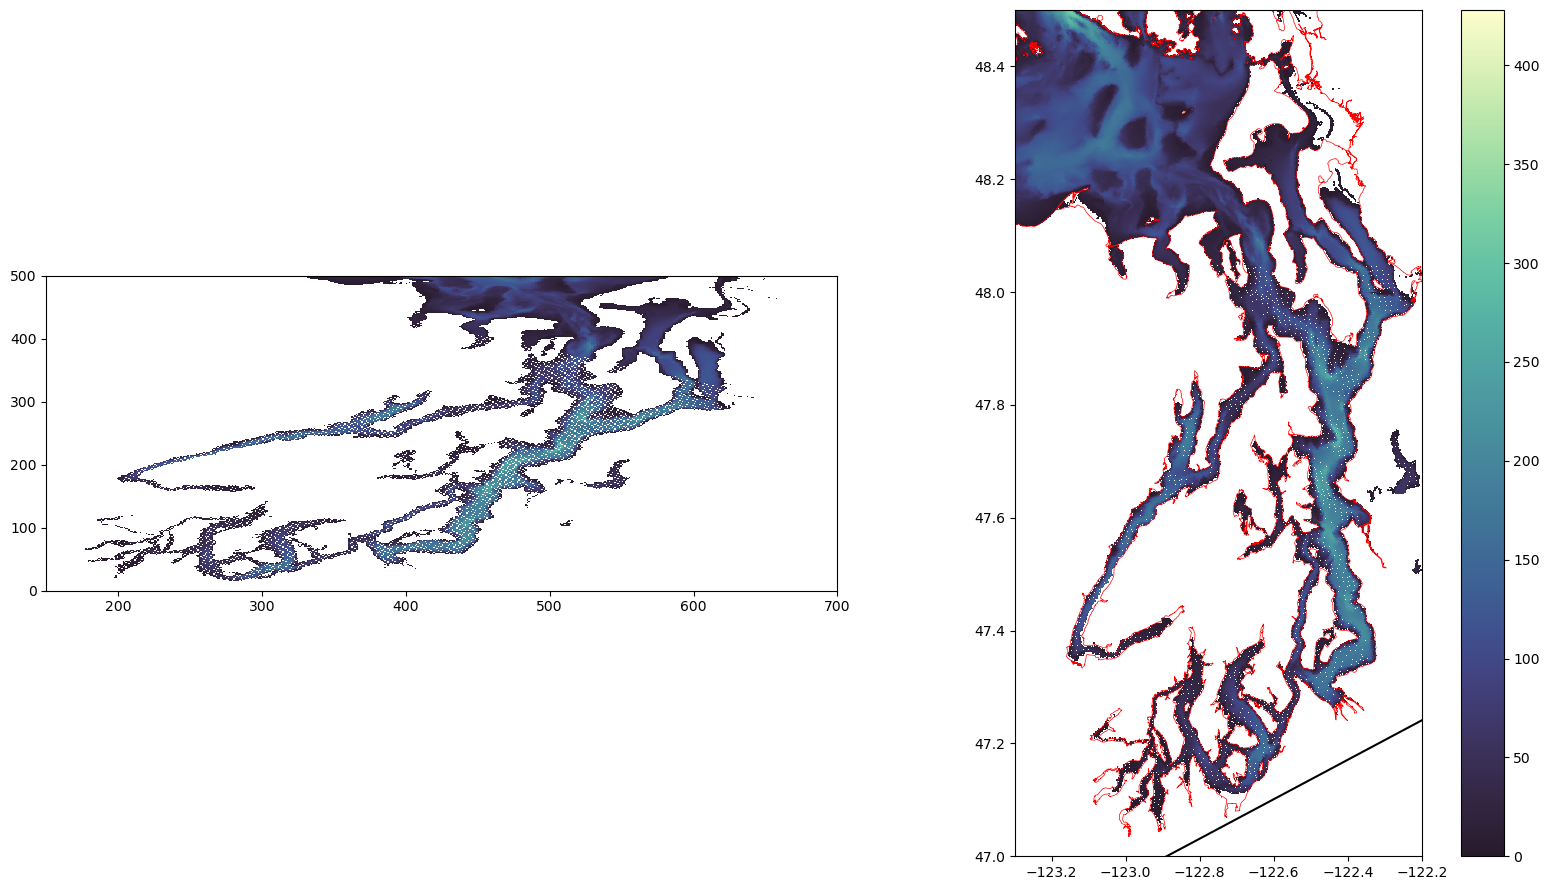

In [23]:
plot_xy_lonlat(dbl_bathy_202405, glamfe, gphife, coastline, rivers, x_lims=(150, 700), y_lims=(0, 500), lon_lims=(-123.3, -122.2), lat_lims=(47, 48.5))

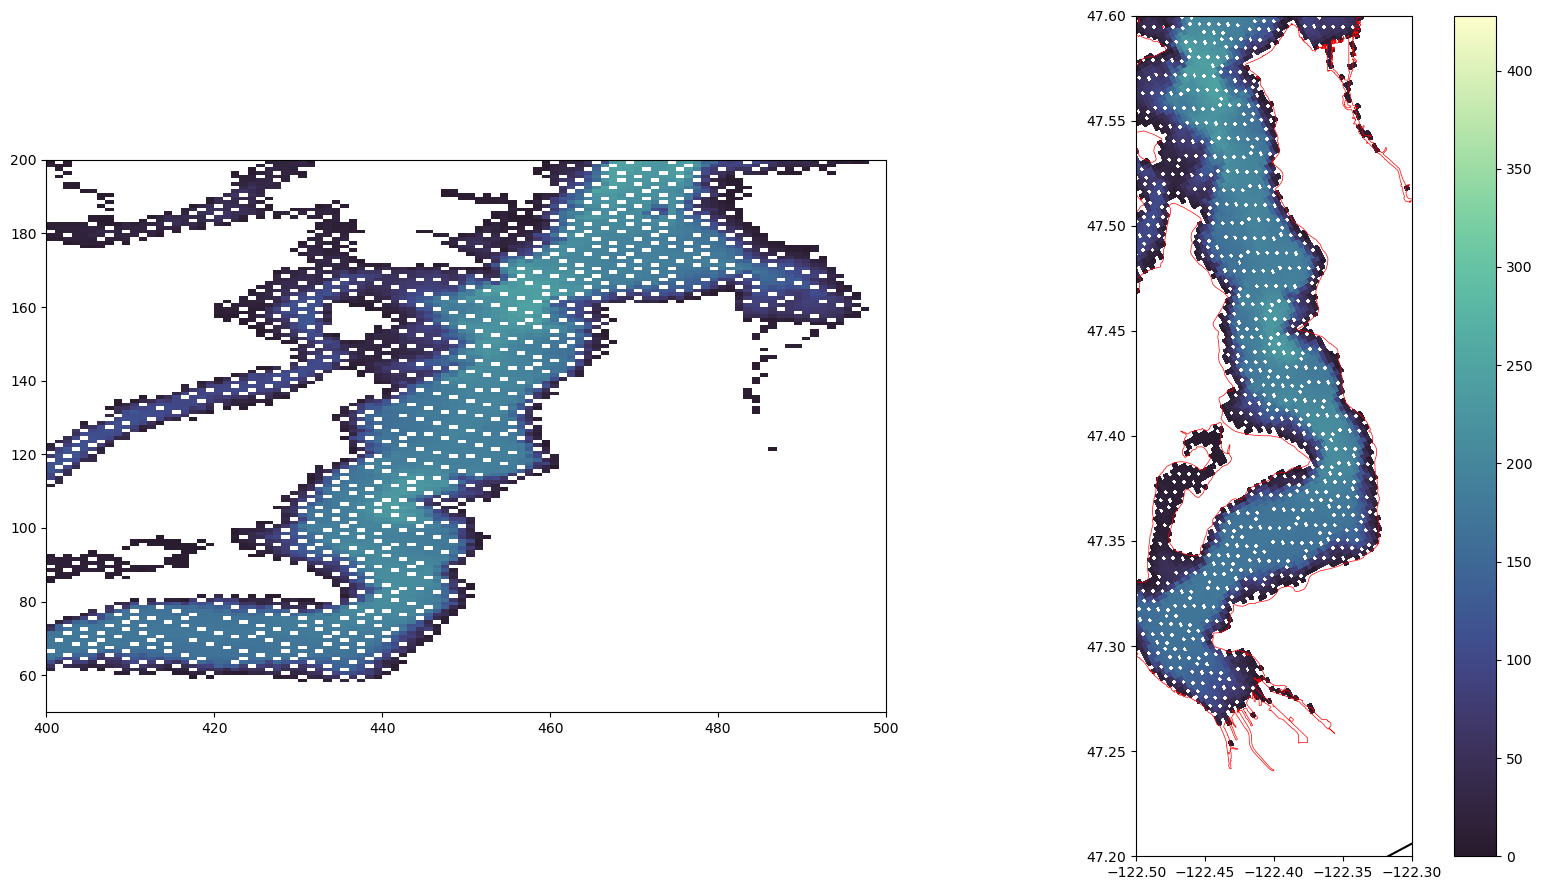

In [24]:
plot_xy_lonlat(dbl_bathy_202405, glamfe, gphife, coastline, rivers, x_lims=(400, 500), y_lims=(50, 200), lon_lims=(-122.5, -122.3), lat_lims=(47.2, 47.6))

### Truncate Vancouver Harbour etc. at First Narrows
Truncate Vancouver Harbour etc. at First Narrows by setting a line of grid cells to zero depth
so that our function derived from `bathy_helpers.lakefill()` will set to zero the depth of the landlocked grid cells that result.

Zoom to First Narrow region to determine grid cell indices to set zero depth for:

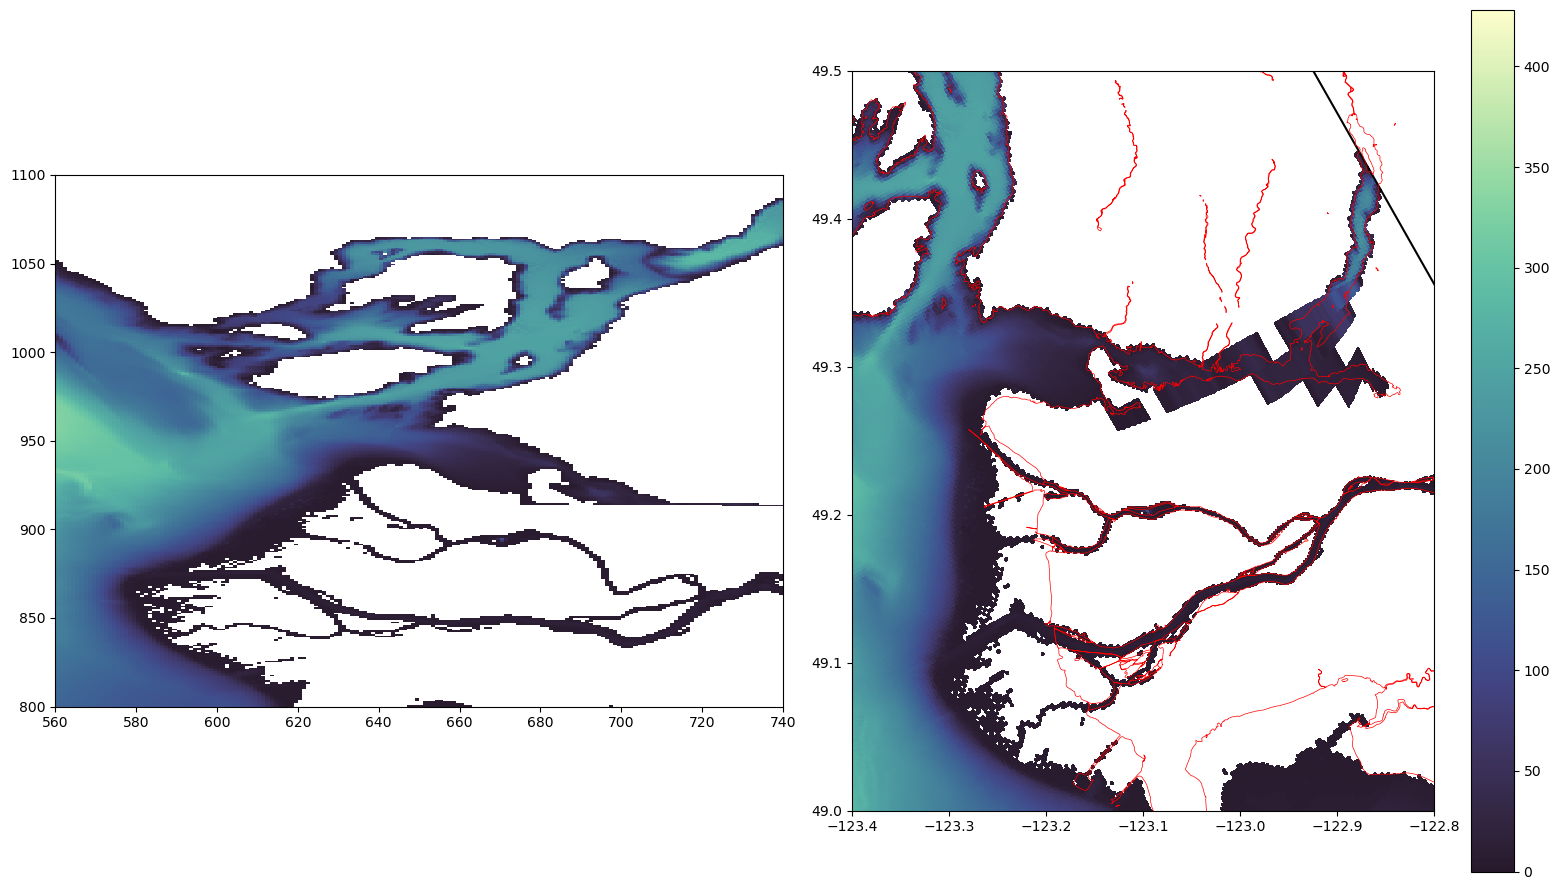

In [25]:
plot_xy_lonlat(dbl_bathy_202405, glamfe, gphife, coastline, rivers, x_lims=(560, 740), y_lims=(800, 1100), lon_lims=(-123.4, -122.8), lat_lims=(49, 49.5))

In [26]:
van_hrbr_bdy = [(684, y) for y in range(933, 941)]
for i, j in van_hrbr_bdy:
    dbl_bathy_202405[j, i] = 0

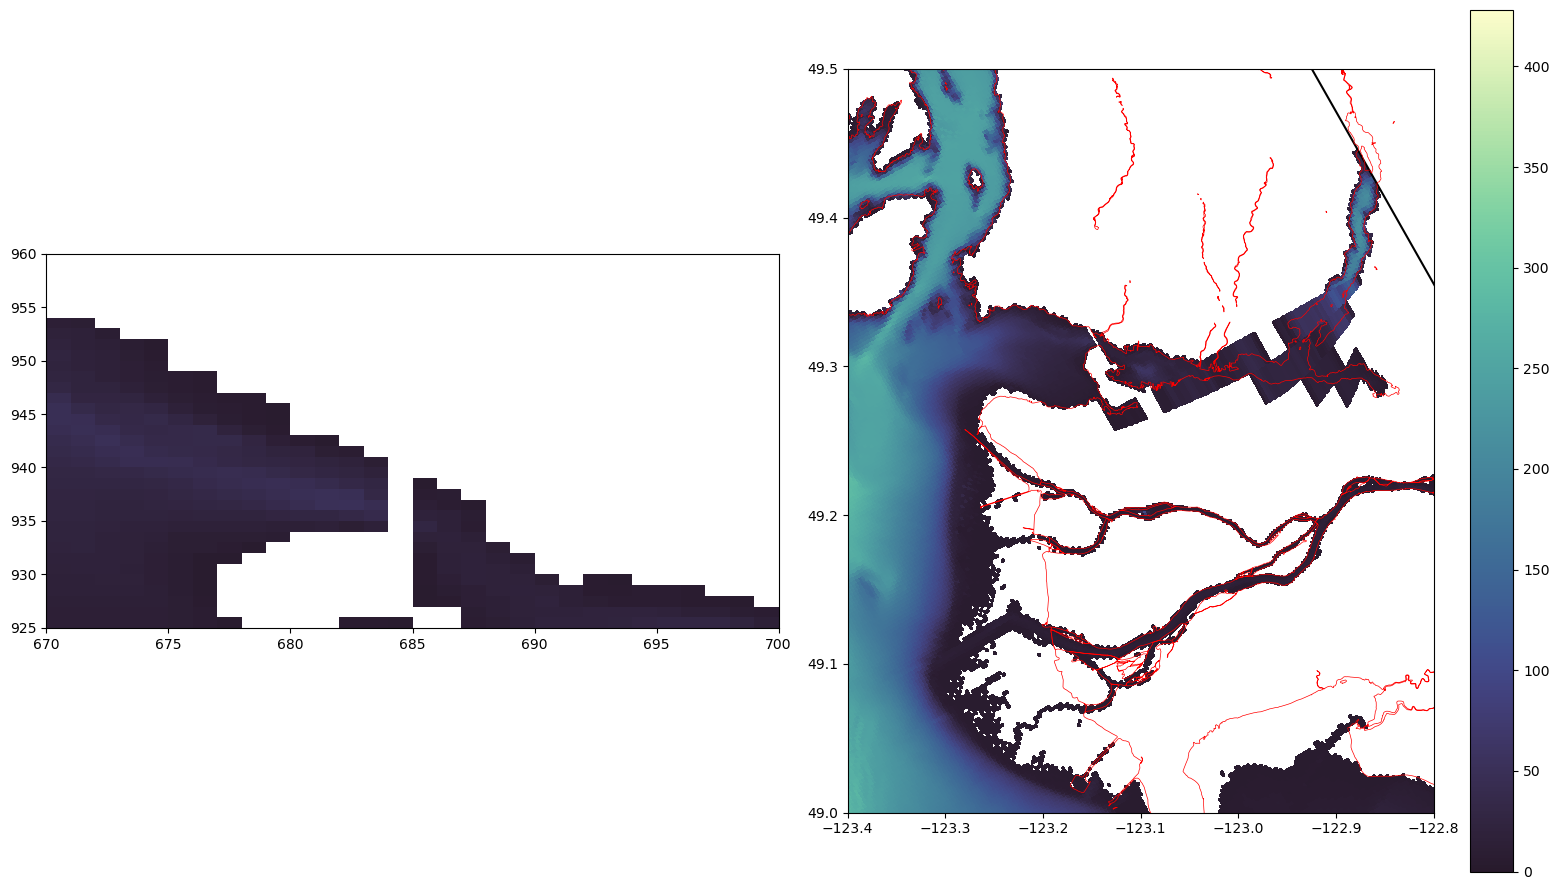

In [27]:
plot_xy_lonlat(dbl_bathy_202405, glamfe, gphife, coastline, rivers, x_lims=(670, 700), y_lims=(925, 960), lon_lims=(-123.4, -122.8), lat_lims=(49, 49.5))

### Truncate False Creek Near Burrard Bridge

Truncate False Creek near Burrard Bridge by setting a line of grid cells to zero depth
so that our function derived from `bathy_helpers.lakefill()` will set to zero the depth of the landlocked grid cells that result.

Zoom to False Creek region to determine grid cell indices to set zero depth for:

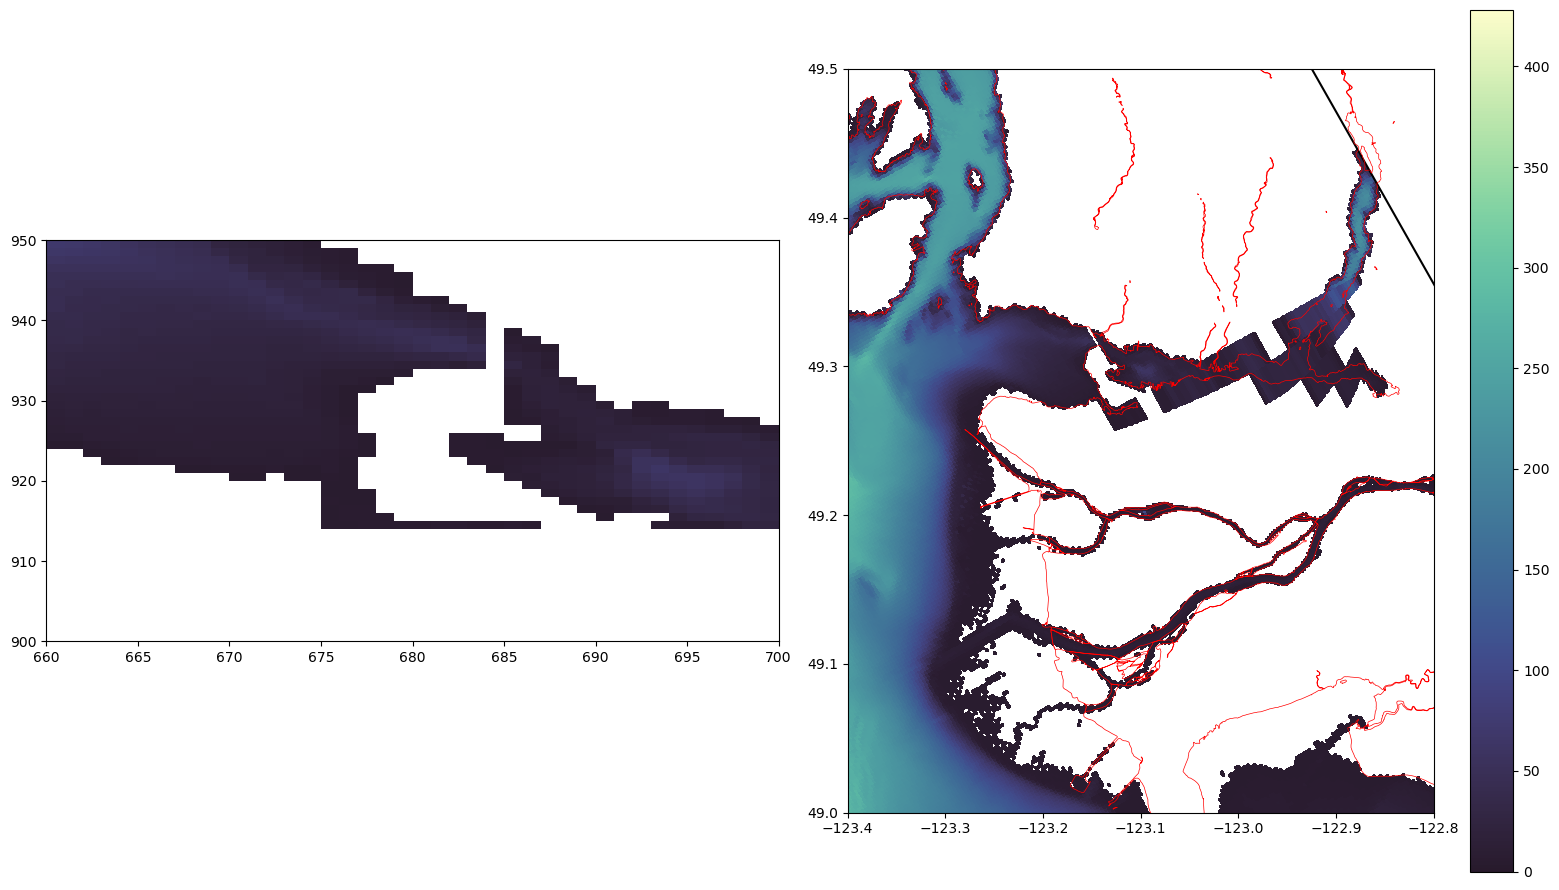

In [28]:
plot_xy_lonlat(dbl_bathy_202405, glamfe, gphife, coastline, rivers, x_lims=(660, 700), y_lims=(900, 950), lon_lims=(-123.4, -122.8), lat_lims=(49, 49.5))

In [29]:
false_crk_bdy = [(x, 919) for x  in range(674, 678)]
for i, j in false_crk_bdy:
    dbl_bathy_202405[j, i] = 0

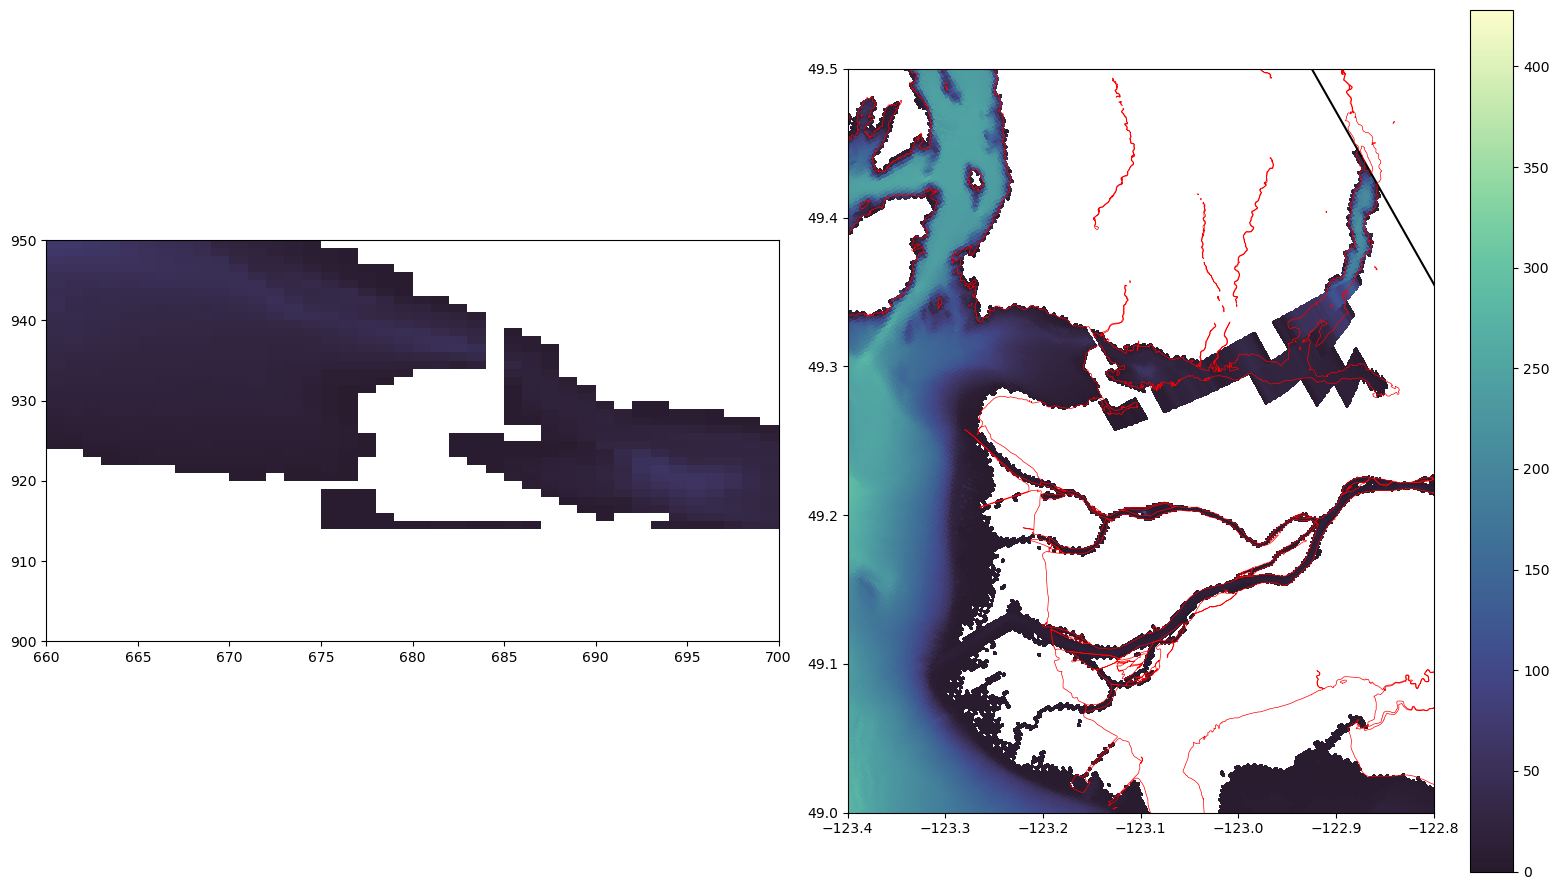

In [30]:
plot_xy_lonlat(dbl_bathy_202405, glamfe, gphife, coastline, rivers, x_lims=(660, 700), y_lims=(900, 950), lon_lims=(-123.4, -122.8), lat_lims=(49, 49.5))

Use a tracer diffusion technique from JP and Michael to identify and set to zero depth all landlocked grid cells.

In [31]:
def lakefill(bathy, water_point):
    """Reimplementation of JP's fill_in_lakes.m via Michael's bathy_helpers.lakefill()
    The strategy is to diffuse a tracer from a known water point in the domain
    through the whole domain in 2D. Any non-land points that the tracer
    doesn't reach are lakes, so we fill them.
    """
    # Diffusion domain
    ocean = numpy.zeros(bathy.shape)
    # Get indices of land points from bathymetry and set them as zero depth in diffusion domain
    idxland = bathy == 0
    ocean[idxland] = 0
    # Put tracer at water point in diffusion domain
    x, y = water_point
    ocean[y-1:y+1, x-1:x+1] = 1

    # Diffusion algorithm
    flag, it = True, 0
    stencil = numpy.array([[0,1,0],[1,0,1],[0,1,0]])
    while flag:
        nocean = numpy.sum(ocean)
        it += 1
        ocean = scipy.signal.convolve2d(ocean, stencil, mode='same')
        # Reset bathymetry land points
        ocean[idxland] = 0
        # Anywhere that has tracer is now wet
        ocean[ocean>0] = 1
        flag = numpy.sum(ocean) > nocean

    # Ocean is connected wet points
    idxwater = ocean == 1
    # Lakes are not ocean and not land
    idxlakes = (~idxwater) & (~idxland)
    # Fill the lakes
    bathyout = numpy.copy(bathy)
    bathyout[idxlakes] = 0
    print (f"Lakes filled in {it} iterations")

    return bathyout

In [32]:
dbl_bathy_202405 = lakefill(dbl_bathy_202405, water_point=(600, 960))

Lakes filled in 1458 iterations


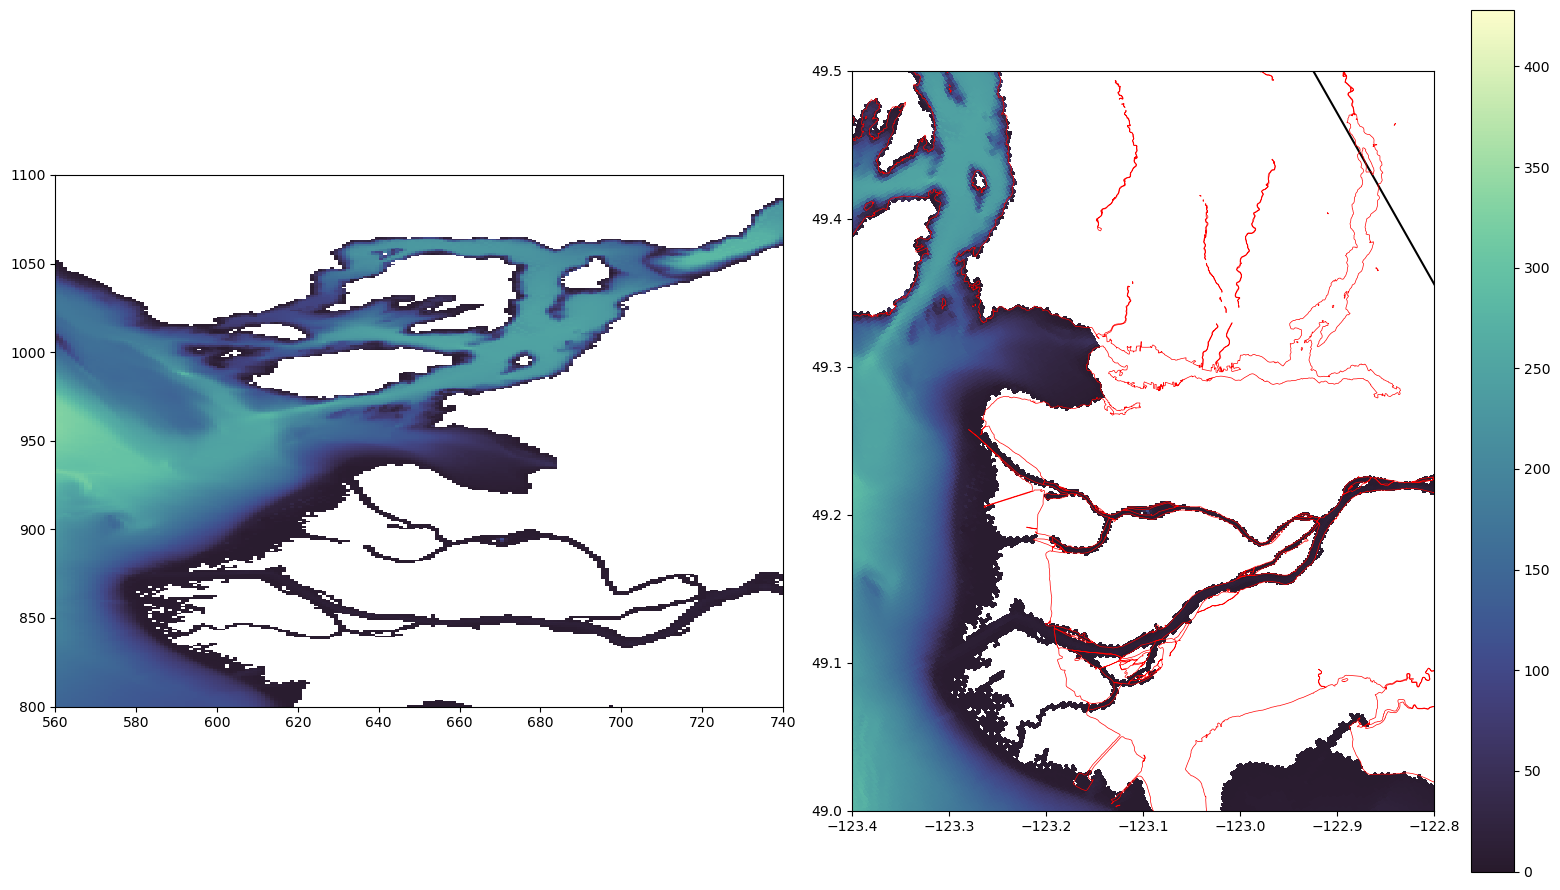

In [33]:
plot_xy_lonlat(dbl_bathy_202405, glamfe, gphife, coastline, rivers, x_lims=(560, 740), y_lims=(800, 1100), lon_lims=(-123.4, -122.8), lat_lims=(49, 49.5))